In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

import sys
from pathlib import Path

sys.path.append(str(Path().resolve().parent))
#sys.path.append(str(Path(__file__).resolve().parent.parent))

from os import listdir
from os.path import isfile, join

import tensorflow as tf
import seaborn as sns

Note: Use conda tf-gpu environment

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Define Data Directory and Batch size

In [39]:
num_classes = 126
batch_size = 32
spec_dir = '../data/image_data/'

## B - <a name="generateurs"></a> Data Generators



In [40]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=(0.8, 1.2),
                                    fill_mode='nearest'
                                   )

val_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )


- (d) Implement ```training_data```, ```valid_data``` splits


In [41]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = val_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)


Found 49204 images belonging to 126 classes.
Found 12242 images belonging to 126 classes.


# II - <a name="classif"></a> Class Distribution



In [42]:
# 1️⃣ Get class names and corresponding labels
class_indices = training_data.class_indices                # dict: {'class_name': index}
classes = list(class_indices.keys())                       # list of class names
labels = training_data.classes                             # array of integers (length = n_samples)

In [43]:
#class_indices

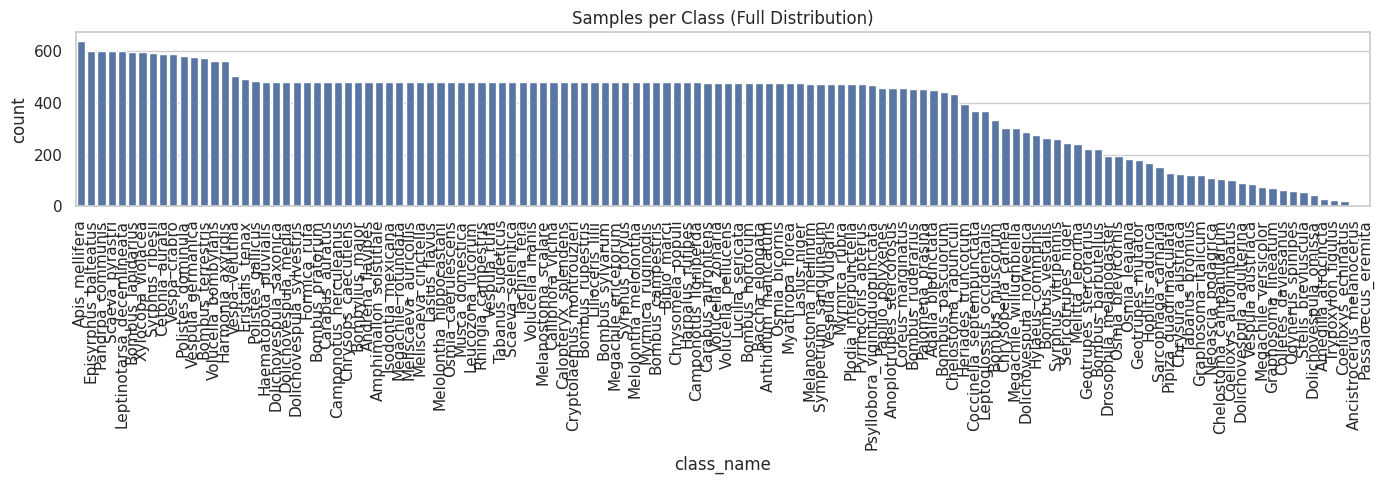

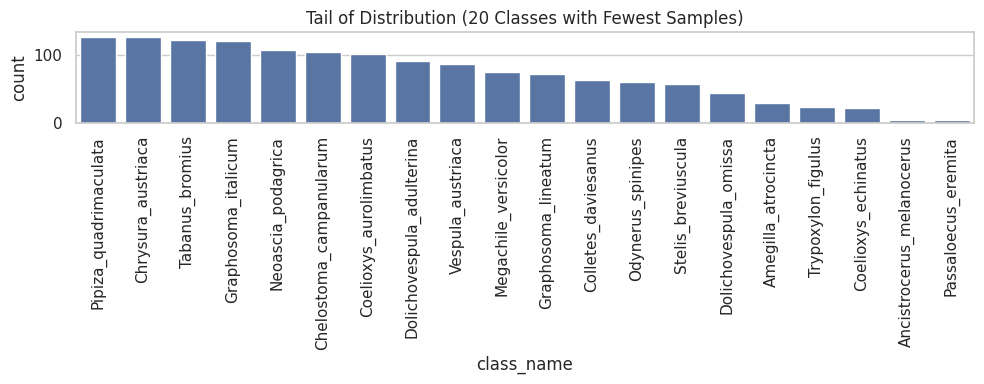

In [44]:
# 1️⃣ Build a DataFrame of class counts
counts = pd.Series(labels).value_counts().rename_axis("class_idx").reset_index(name="count")
idx_to_class = {v: k for k, v in class_indices.items()}
counts["class_name"] = counts["class_idx"].map(idx_to_class)

# 2️⃣ Sort by count
counts_sorted = counts.sort_values(by="count", ascending=False)

# 3️⃣ Plot full distribution
plt.figure(figsize=(14, 5))
sns.barplot(x="class_name", y="count", data=counts_sorted)
plt.xticks(rotation=90)
plt.title("Samples per Class (Full Distribution)")
plt.tight_layout()
plt.show()

# 4️⃣ Plot tail (20 smallest classes)
tail = counts_sorted.tail(20)

plt.figure(figsize=(10, 4))
sns.barplot(x="class_name", y="count", data=tail)
plt.xticks(rotation=90)
plt.title("Tail of Distribution (20 Classes with Fewest Samples)")
plt.tight_layout()
plt.show()

# III - <a name="classif"></a> Plot Accuracy vs Sample size

In [45]:
exp_no=2
#project_root = Path().resolve().parent
project_root = Path(str(Path().resolve().parent))
metrics_save_path = project_root / "results" / "metrics"
per_class_accuracy = np.load(metrics_save_path / f"Exp{exp_no}_per_class_accuracy.npy")

In [47]:
counts_by_classname = counts.sort_values(by="class_name", ascending=True)
counts_by_classname.head(3)

,class_idx,count,class_name
83,0,448,Adalia_bipunctata
121,1,30,Amegilla_atrocincta
29,2,480,Amphimallon_solstitiale


In [48]:
counts_by_classname["accuracy"] = per_class_accuracy

In [49]:
df_sorted = counts_by_classname.sort_values(by="count", ascending=False).tail(30)
#df_sorted = df_sorted.tail(30)

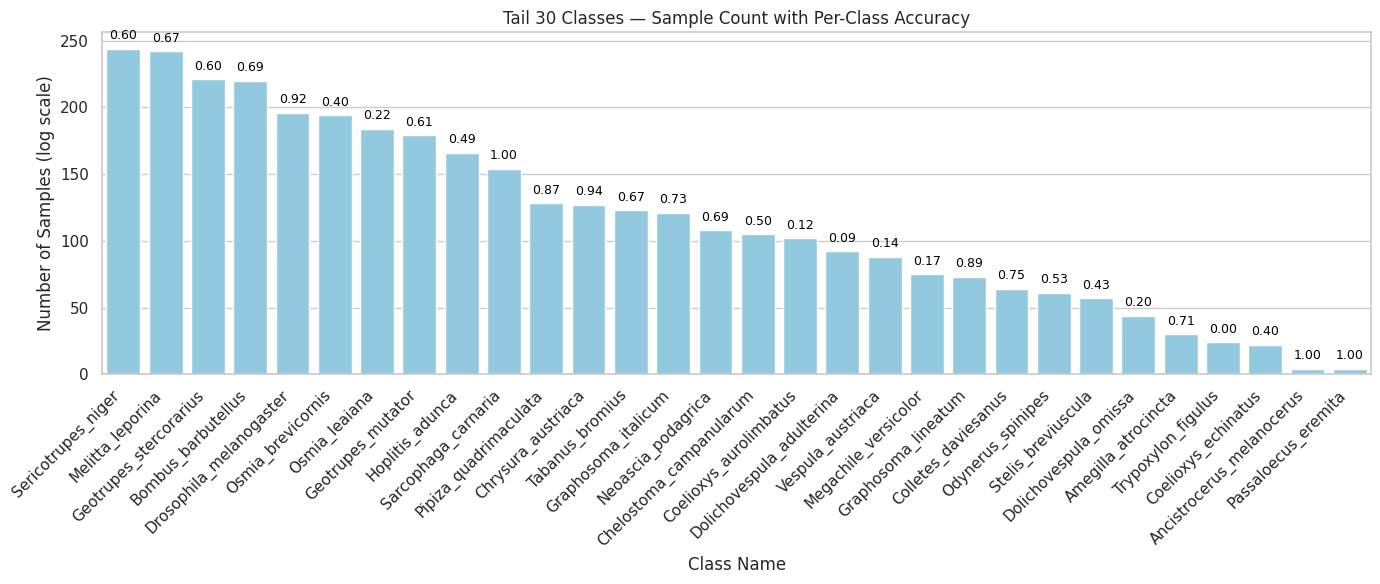

In [51]:
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

# Bar plot
bars = sns.barplot(
    x='class_name', 
    y='count', 
    data=df_sorted, 
    color='skyblue'
)

# Offset for label placement (for clarity)
y_offset = 0.02 * df_sorted['count'].max()

# Add accuracy text above each bar
for i, row in enumerate(df_sorted.itertuples()):
    plt.text(
        i, 
        row.count + y_offset, 
        f"{row.accuracy:.2f}", 
        ha='center', 
        va='bottom', 
        fontsize=9, 
        color='black'
    )

# Optional: use log scale if distribution is long-tailed
#plt.yscale('log')

# Styling
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Name")
plt.ylabel("Number of Samples (log scale)")
plt.title("Tail 30 Classes — Sample Count with Per-Class Accuracy")
plt.tight_layout()
plt.show()